# Hourly traffic volume prediction on Interstate 94

### Multivariate time series prediction with getML

In this tutorial, we demonstrate a time series application of getML. We predict the hourly traffic volume on I-94 westbound from Minneapolis-St Paul. 
We benchmark our results against [Facebook's Prophet](https://facebook.github.io/prophet/). getML's relational learning algorithms outperform Prophet's classical time series approach by ~15%.

Summary:

- Prediction type: __Regression model__
- Domain: __Transportation__
- Prediction target: __Hourly traffic volume__ 
- Source data: __Multivariate time series, 5 components__
- Population size: __24096__

_Author: Sören Nikolaus_

# Background

The dataset features some particularly interesting characteristics common for time series, which classical models may struggle to deal with appropriately. Such characteristics are:

- High frequency (hourly)
- Dependence on irregular events (holidays)
- Strong and overlapping cycles (daily, weekly)
- Anomalies
- Multiple seasonalities


The analysis is built on top of a dataset provided by the [MN Department of Transportation](https://www.dot.state.mn.us), with some data preparation done by [John Hogue](https://github.com/dreyco676/Anomaly_Detection_A_to_Z/). 

### A web frontend for getML

The getML monitor is a frontend built to support your work with getML. The getML monitor displays information such as the imported data frames, trained pipelines and allows easy data and feature exploration. You can launch the getML monitor [here](http://localhost:1709).

### Where is this running?

Your getML live session is running inside a docker container on [mybinder.org](https://mybinder.org/), a service built by the Jupyter community and funded by Google Cloud, OVH, GESIS Notebooks and the Turing Institute. As it is a free service, this session will shut down after 10 minutes of inactivity.

# Analysis

Let's get started with the analysis and set-up your session:

In [1]:
import os
import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline  

import getml

print(f"getML API version: {getml.__version__}\n")

getml.engine.set_project('interstate94')

getML API version: 0.14.0


Connected to project 'interstate94'


## 1. Loading data

### 1.1 Download from source

Downloading the raw data and convert it into a prediction ready format takes time. To get to the getML model building as fast as possible, we prepared the data for you and excluded the code from this notebook. It is made available in the example notebook featuring the full analysis. We only include data after 2016 and introduced a fixed train/test split at 80% of the available data. 

In [2]:
data = getml.datasets.load_interstate94(roles=True, units=True)
traffic_test, traffic_train, _ = data.values()
traffic = getml.data.concat("traffic", [traffic_train, traffic_test])

### 1.2 Prepare data for getML

The `getml.datasets.load_interstate94` method took care of the entire data preparation:
* Downloads csv's from our servers into python
* Converts csv's to getML [DataFrames]()
* Sets [roles]() & [units]() to columns inside getML DataFrames

__Data visualization__

The first week of the original traffic time series is plotted below.

In [3]:
col_data = 'black'
col_getml = 'darkviolet'

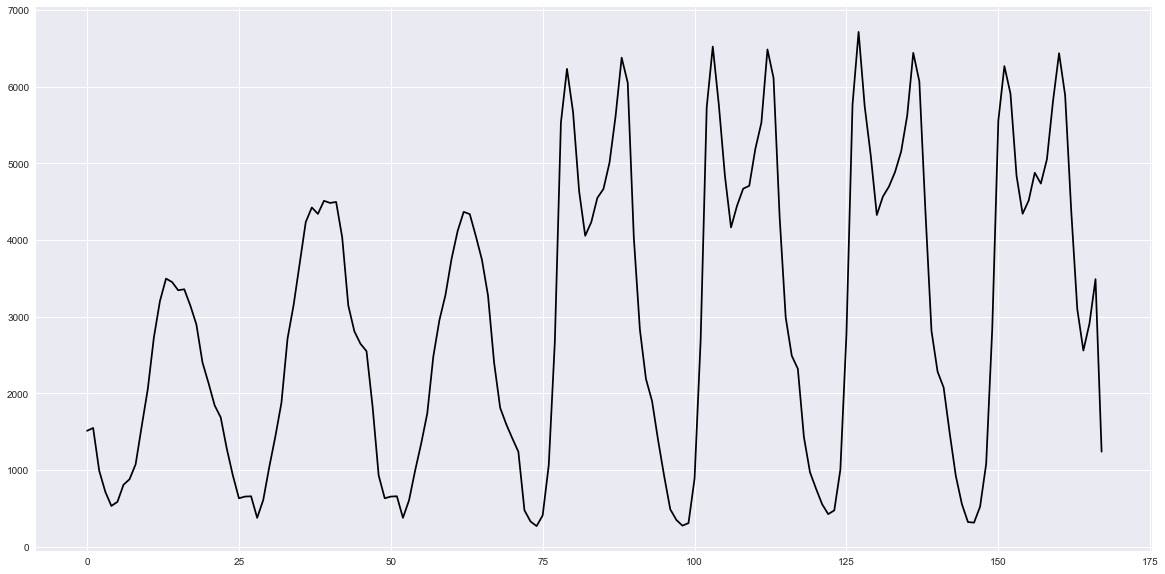

In [4]:
plt.subplots(figsize=(20, 10))

length = 168

plt.plot(traffic["Traffic_Volume"].to_numpy()[:length], color=col_data)

__Traffic__: population table

To allow the algorithm to capture seasonal information, we include time components (such as the day of the week) as categorical variables. Note that we could have also used getML's Seasonal preprocessor (`getml.prepreprocessors.Seasonal()`), but in this case the information was already included in the dataset.

In [5]:
traffic

Name,ds,join_key,Traffic_Volume,holiday,hour,weekday,day,month,year,lower_window,upper_window,ds_day
Role,time_stamp,join_key,target,categorical,categorical,categorical,categorical,categorical,categorical,unused_float,unused_float,unused_string
Unit,"time stamp, comparison only",,,,hour,weekday,day,month,year,,,
0,2016-01-01T00:00:00.000000Z,1,1513,New Years Day,0,4,1,1,2016,-1,0,2016-01-01 00:00:00
1,2016-01-01T01:00:00.000000Z,1,1550,New Years Day,1,4,1,1,2016,-1,0,2016-01-01 00:00:00
2,2016-01-01T02:00:00.000000Z,1,993,New Years Day,2,4,1,1,2016,-1,0,2016-01-01 00:00:00
3,2016-01-01T03:00:00.000000Z,1,719,New Years Day,3,4,1,1,2016,-1,0,2016-01-01 00:00:00
4,2016-01-01T04:00:00.000000Z,1,533,New Years Day,4,4,1,1,2016,-1,0,2016-01-01 00:00:00
,...,...,...,...,...,...,...,...,...,...,...,...
24091,2018-09-30T19:00:00.000000Z,1,3543,No holiday,19,6,30,9,2018,nan,nan,2018-09-30 00:00:00
24092,2018-09-30T20:00:00.000000Z,1,2781,No holiday,20,6,30,9,2018,nan,nan,2018-09-30 00:00:00


### 1.3 Define relational model

To start with relational learning, we need to specify the data model. We manually replicate the appropriate time series structure by setting time series related join conditions (`horizon`, `memory` and `allow_lagged_targets`). This is done abstractly using [Placeholders](https://docs.getml.com/latest/user_guide/data_model/data_model.html#placeholders)

The data model consists of two tables:
* __Population table__ `traffic_{test/train}`: holds target and the contemporarily available time-based components
* __Peripheral table__ `traffic`: same table as the population table
* Join between both placeholders specifies (`horizon`) to prevent leaks and (`memory`) that keeps the computations feasible

In [6]:
population = getml.data.Placeholder('population')

peripheral = getml.data.Placeholder('peripheral')

# 1. The horizon is 1 hour (we predict the next hour). 
# 2. The memory is 7 days, so we allow the algorithm to 
#    use information from up to 7 days. 
# 3. We allow lagged targets. Thus the algorithm can 
#    identify autoregressive processes.

population.join(
    peripheral,
    join_key='join_key',
    time_stamp='ds',
    horizon=getml.data.time.hours(1),
    memory=getml.data.time.days(7),
    allow_lagged_targets=True
)

population

placeholder   other placeholder   allow lagged targets   horizon   join keys used   ...   
population    peripheral          True                   3600.0    join_key         ...   



other join keys used   other time stamps used   relationship   time stamps used   
join_key               ds                       many-to-many   ds                 



other join keys used   upper time stamps used   
join_key

## 2.Predictive modelling

We loaded the data, defined the roles, units and the abstract data model. Next, we create a getML pipeline for relational learning.

### 2.1 getML Pipeline

<!-- #### 2.1.1  -->
__Set-up of feature learners, selectors & predictor__

In [7]:
relmt = getml.feature_learning.RelMTModel(
    num_features=10,
    loss_function=getml.feature_learning.loss_functions.SquareLoss,
    seed=4367,
    num_threads=1
)

predictor = getml.predictors.XGBoostRegressor()

__Build the pipeline__

In [8]:
pipe = getml.pipeline.Pipeline(
    tags=['memory: 7d', 'horizon: 1h', 'relmt'],
    population=population,
    peripheral=[peripheral],
    feature_learners=[relmt],
    predictors=[predictor]
)

### 2.2 Model training

In [9]:
pipe.fit(traffic_train, [traffic])

Checking data model...
OK.

RelMT: Training features...
[========================================] 100%

RelMT: Building features...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:3m:58.487464



Pipeline(preprocessors=[], feature_learners=['RelMTModel'], 
         feature_selectors=[], include_categorical=False, 
         peripheral=['peripheral'], population='population', 
         predictors=['XGBoostRegressor'], 
         tags=['memory: 7d', 'horizon: 1h', 'relmt'], 
         share_selected_features=0.5)

url: http://localhost:1709/#/getpipeline/interstate94/WxFWKD/0/

### 2.3 Model evaluation

In [10]:
pipe.score(
    population_table=traffic_test,
    peripheral_tables=[traffic]
)


RelMT: Building features...
[========================================] 100%



,date time,set used,target,mae,rmse,rsquared
0,2021-01-03 11:47:00,traffic_train,Traffic_Volume,188.83083,279.51818,0.97979
1,2021-01-03 11:47:05,traffic_test,Traffic_Volume,172.29247,255.75927,0.98345


### 2.4 Studying features

__Feature correlations__

Correlations of the calculated features with the target

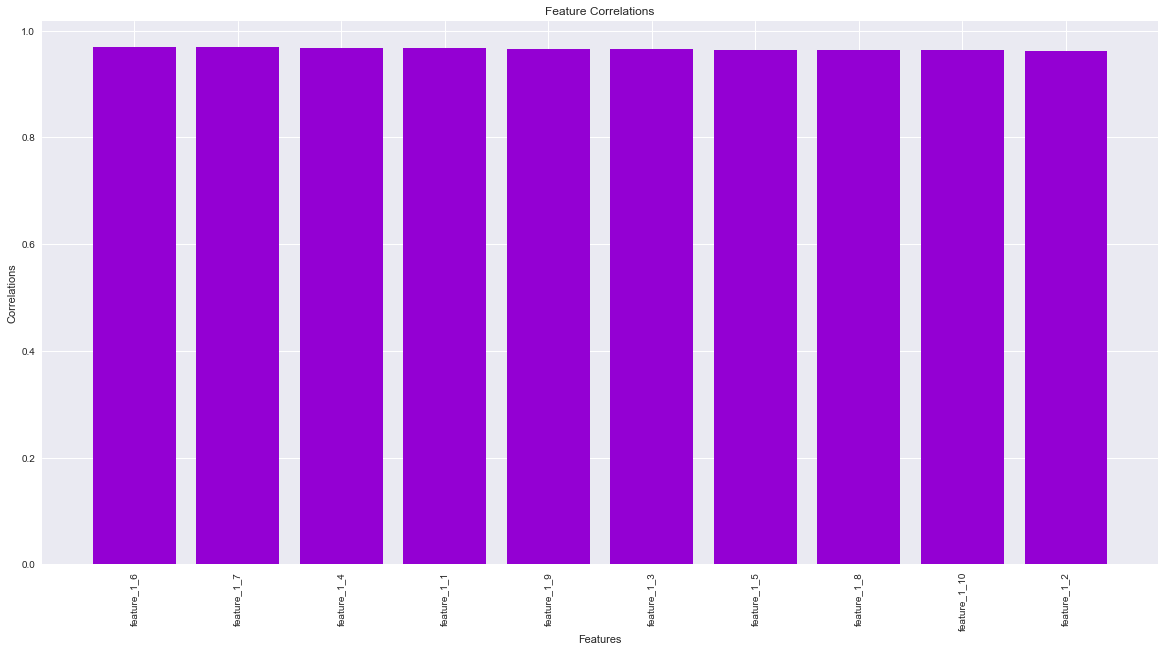

In [11]:
names, correlations = pipe.features.correlations()

plt.subplots(figsize=(20, 10))

plt.bar(names, correlations, color=col_getml)
plt.title('Feature Correlations')
plt.xlabel('Features')
plt.ylabel('Correlations')
plt.xticks(rotation='vertical')
plt.show()

__Feature importances__

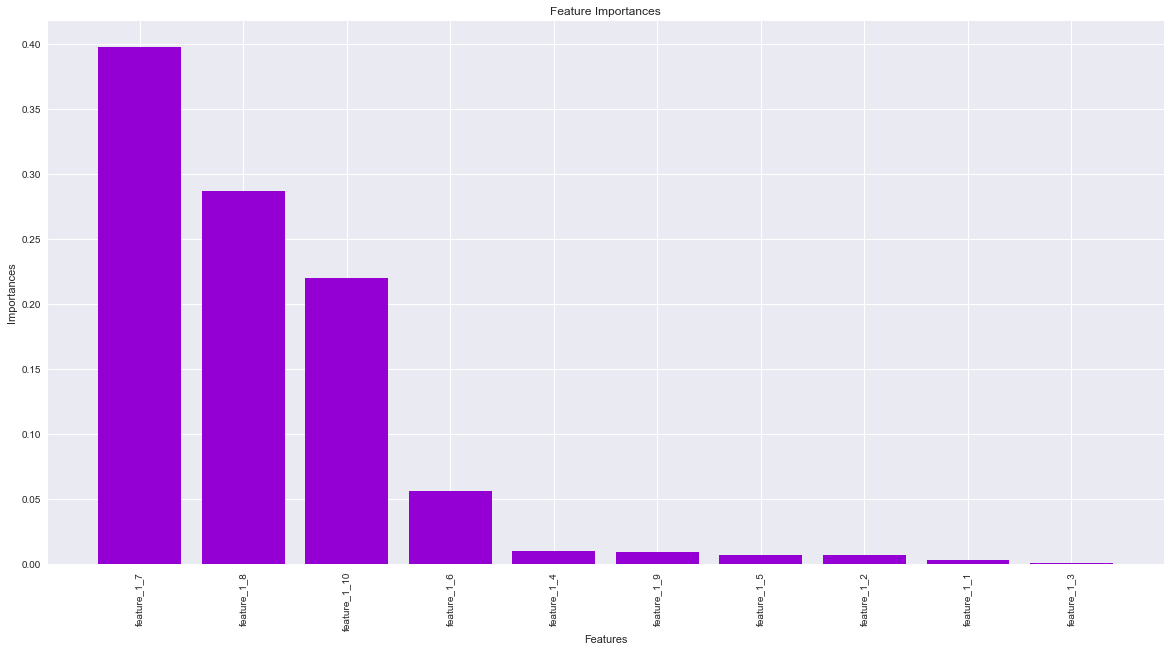

In [12]:
names, importances = pipe.features.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color=col_getml)
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importances')
plt.xticks(rotation='vertical')
plt.show()

__Viszualizing the learned features__

We can also transpile the features as SQL code. Here, we can see the most important feature (`names` is already sorted by importance).

In [13]:
most_important = names[0]

pipe.features.to_sql()[most_important]

```sql
DROP TABLE IF EXISTS "FEATURE_1_7";

CREATE TABLE "FEATURE_1_7" AS
SELECT SUM( 
    CASE
        WHEN ( julianday( t1."ds" ) > julianday( t2."ds", '+1.935574 hours' ) ) AND ( t2."hour" IN ( '3' ) ) THEN COALESCE( julianday( t1."ds" ) - julianday( '1970-01-01' ) - 17204.83683487743, 0.0 ) * -139.3069051439147 + COALESCE( t2."Traffic_Volume" - 3301.466611321538, 0.0 ) * -0.01008383507114677 + COALESCE( julianday( t2."ds" ) - julianday( '1970-01-01' ) - 17202.5, 0.0 ) * 69.62606287378428 + COALESCE( julianday( t2."ds", '+1.000000 hours' ) - julianday( '1970-01-01' ) - 17202.54166666667, 0.0 ) * 69.62606287375563 + 4.9740956129893767e+01
        WHEN ( julianday( t1."ds" ) > julianday( t2."ds", '+1.935574 hours' ) ) AND ( t2."hour" NOT IN ( '3' ) ) THEN COALESCE( julianday( t1."ds" ) - julianday( '1970-01-01' ) - 17204.83683487743, 0.0 ) * 3.677123259276891 + COALESCE( t2."Traffic_Volume" - 3301.466611321538, 0.0 ) * 9.391483274561951e-05 + COALESCE( julianday( t2."ds" ) - julianday( '1970-01-01' ) - 17202.5, 0.0 ) * -1.836488348026519 + COALESCE( julianday( t2."ds", '+1.000000 hours' ) - julianday( '1970-01-01' ) - 17202.54166666667, 0.0 ) * -1.83648710220104 + 3.2661188828459600e+00
        WHEN ( julianday( t1."ds" ) <= julianday( t2."ds", '+1.935574 hours' ) OR julianday( t1."ds" ) IS NULL OR julianday( t2."ds", '+1.935574 hours' ) IS NULL ) AND ( t2."hour" IN ( '7', '8', '9', '17', '18', '19', '21', '22', '23', '3' ) ) THEN COALESCE( julianday( t1."ds" ) - julianday( '1970-01-01' ) - 17204.83683487743, 0.0 ) * -0.09533120746131131 + COALESCE( t2."Traffic_Volume" - 3301.466611321538, 0.0 ) * 0.3980938836171733 + COALESCE( julianday( t2."ds" ) - julianday( '1970-01-01' ) - 17202.5, 0.0 ) * -0.08449554459252261 + COALESCE( julianday( t2."ds", '+1.000000 hours' ) - julianday( '1970-01-01' ) - 17202.54166666667, 0.0 ) * -0.08449546134238185 + 2.5923395653911007e+02
        WHEN ( julianday( t1."ds" ) <= julianday( t2."ds", '+1.935574 hours' ) OR julianday( t1."ds" ) IS NULL OR julianday( t2."ds", '+1.935574 hours' ) IS NULL ) AND ( t2."hour" NOT IN ( '7', '8', '9', '17', '18', '19', '21', '22', '23', '3' ) ) THEN COALESCE( julianday( t1."ds" ) - julianday( '1970-01-01' ) - 17204.83683487743, 0.0 ) * -0.08736752652950087 + COALESCE( t2."Traffic_Volume" - 3301.466611321538, 0.0 ) * 0.4953907636519483 + COALESCE( julianday( t2."ds" ) - julianday( '1970-01-01' ) - 17202.5, 0.0 ) * -0.1100083407899622 + COALESCE( julianday( t2."ds", '+1.000000 hours' ) - julianday( '1970-01-01' ) - 17202.54166666667, 0.0 ) * -0.1092495713647454 + 6.4452566751546453e+02
        ELSE NULL
    END
) AS "feature_1_7",
     t1.rowid AS "rownum"
FROM "population" t1
LEFT JOIN "peripheral" t2
ON t1."join_key" = t2."join_key"
WHERE julianday( t2."ds", '+1.000000 hours' ) <= julianday( t1."ds" )
AND ( julianday( t2."ds", '+7.041667 days' ) > julianday( t1."ds" ) OR julianday( t2."ds", '+7.041667 days' ) IS NULL )
GROUP BY t1.rowid;
```

__Plot predictions & traffic volume vs. time__

We now plot the predictions against the observed values of the target for the first 7 days of the testing set. You can see that the predictions closely follows the original series. RelMT was able to identify certain patterns in the series, including:
- Day and night separation 
- The daily commuting peeks (on weekdays)
- The decline on weekends



In [14]:
predictions = pipe.predict(traffic_test, [traffic])


RelMT: Building features...
[========================================] 100%



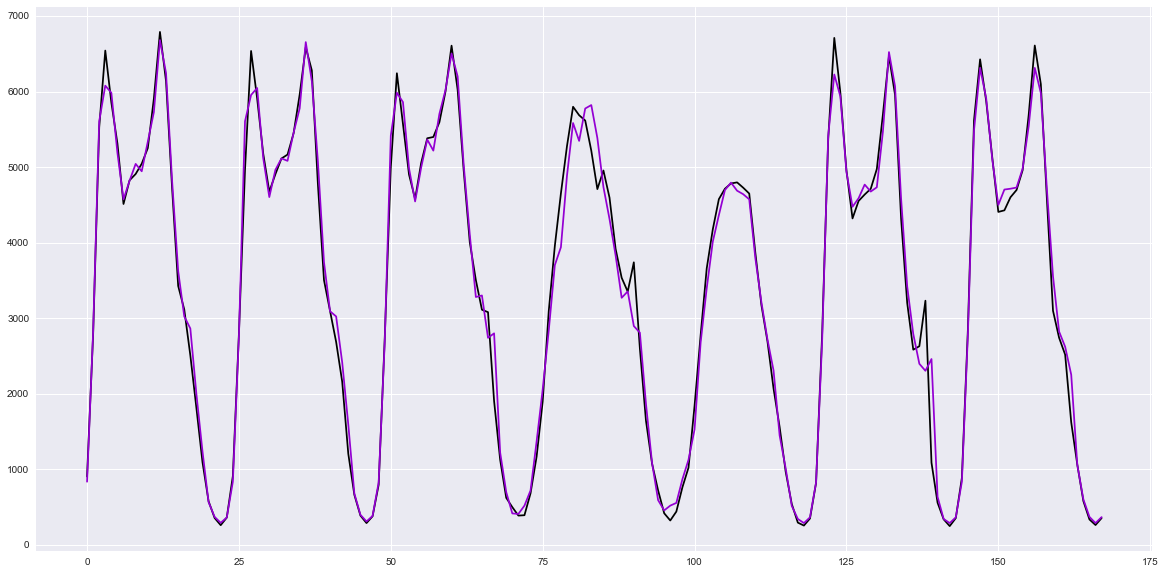

In [15]:
plt.subplots(figsize=(20, 10))

length = 168

plt.plot(traffic_test["Traffic_Volume"].to_numpy()[:length], color=col_data)
plt.plot(predictions[:length], color=col_getml)

plt.show()

## 3. Conclusion

__Benchmarks against Prophet__

By design, Prophet isn't capable of delivering the 1-step ahead predictions we did with getML. To retrieve a benchmark in the 1-step case nonetheless, we mimic 1-step ahead predictions through cross-validating the model on a rolling origin. This gives Prophet an advantage as all information up to the origin is incorporated when *fitting* the model and a new fit is calculated for every 1-step ahead forecast. If you are interested in the full analysis please refer to the extended version of this [notebook](getml_examples/interstate94/interstate94.ipynb).


__Results__

We have benchmarked getML against Facebook’s Prophet library on a univariate time series with strong seasonal components.
Prophet is made for exactly these sort of data sets, so you would expect this to be a home run for Prophet. The opposite is true - getML’s relational learning algorithms outperform Prophet's 1-step ahead predictions by ~15 percentage points:

* R-squared Prophet: 83.3%
* R-squared getML: 98.4%

# Next Steps

This tutorial went through the basics of applying getML to time series. If you want to learn more about getML, here are some additional tutorials and articles that will help you:

__Tutorials:__
* [Loan default prediction: Introduction to relational learning](loans_demo.ipynb)
* [Occupancy detection: A multivariate time series example](occupancy_demo.ipynb)  
* [Expenditure categorization: Why relational learning matters](consumer_expenditures_demo.ipynb)
* [Disease lethality prediction: Feature engineering and the curse of dimensionality](atherosclerosis_demo.ipynb)
* [Traffic volume prediction: Feature engineering on multivariate time series](interstate94_demo.ipynb)
* [Air pollution prediction: Why feature learning outperforms brute-force approaches](air_pollution_demo.ipynb) 


__User Guides__ (from our [documentation](https://docs.getml.com/latest/)):
* [Feature learning with Multirel](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#multirel)
* [Feature learning with Relboost](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#relboost)


While this tutorial focuses on the new aspects when working with getML, some more steps were required to prepare the raw data in its relational format. You will find the full analysis on Github in our [getml-examples](https://github.com/getml/getml-examples) repository.


# Get in contact

If you have any question schedule a [call with Alex](https://go.getml.com/meetings/alexander-uhlig/getml-demo), the co-founder of getML, or write us an [email](team@getml.com). Prefer a private demo of getML? Just contact us to make an appointment.